In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline


In [300]:
pay = pd.read_csv('C:\\Users\\eyon0\\OneDrive\\桌面\\PropensityToPay\\before_model.csv')

In [301]:
pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45841 entries, 0 to 45840
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cust_Num                    45841 non-null  int64  
 1   Customer.Group              45841 non-null  object 
 2   Payment.Method.description  45841 non-null  object 
 3   DocumentNo                  45841 non-null  int64  
 4   Amount                      45841 non-null  float64
 5   Clrng.doc.                  45841 non-null  int64  
 6   ZIPCODE                     45841 non-null  object 
 7   Region                      45841 non-null  object 
 8   City                        45841 non-null  object 
 9   Customer.Name               45841 non-null  object 
 10  Age.Of.Customer.Months.     45841 non-null  float64
 11  Age.Of.Customer.Year.       45841 non-null  float64
 12  Payment.Term                45841 non-null  int64  
 13  Days.Overdue..Delay.        458

In [302]:
pay= pay.join(pd.get_dummies(pay['Payment.Method.description'],drop_first = True)) 


In [83]:
pay=pay.join(pd.get_dummies(pay['Amount_bin'],drop_first=True))

In [303]:
pay.columns

Index(['Cust_Num', 'Customer.Group', 'Payment.Method.description',
       'DocumentNo', 'Amount', 'Clrng.doc.', 'ZIPCODE', 'Region', 'City',
       'Customer.Name', 'Age.Of.Customer.Months.', 'Age.Of.Customer.Year.',
       'Payment.Term', 'Days.Overdue..Delay.', 'docdate', 'netduedate',
       'postingdate', 'clearingdate', 'flag', 'Key Account', 'Key Region',
       'long term', 'week_pay', 'week_due', 'log_Amount', 'Amount_bin',
       'Direct Debits 2', 'No Payment Method', 'Regulatory ', 'Regulatory 1',
       'Regulatory 2', 'Third Part Payments', 'Wire'],
      dtype='object')

In [86]:
from collections import Counter

In [304]:
#rf classify
#Select dependent and independent variables.
#Independent variables: use the 6 variables from correlation analysis
#flag
#name.iloc[:,np.r_[]]
name2 = ['Amount','Age.Of.Customer.Year.','Payment.Term','Direct Debits 2','No Payment Method','Regulatory 2',
        'Third Part Payments','Wire','Regulatory 1','Regulatory ']
x2 = pay[name2]
y2 = pay['flag']#Select dependent and independent variables.
#Independent variables: use the 6 variables from correlation analysis


In [305]:
#Split dataset into training and testing
from sklearn.model_selection import train_test_split
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x2, y2,
                                                   test_size = 0.2, stratify=y2,
                                                   random_state = 123
                                                   )

In [306]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                replacement=False,
                                sampling_strategy="auto",
                                random_state=0)
bbc.fit(x_train_2, y_train_2) 
y_pred_2=bbc.predict(x_test_2)


In [296]:
Counter(y_pred_2)


Counter({'1-30days': 4696, '=<0': 4308, '31-60days': 134, '>60': 31})

In [237]:
Counter(y2)

Counter({'1-30days': 23478, '=<0': 21540, '31-60days': 667, '>60': 156})

In [253]:
y_test_2.head()

13128    1-30days
34679         =<0
431      1-30days
12770    1-30days
5304     1-30days
Name: flag, dtype: object

In [307]:
from sklearn.preprocessing import label_binarize
y_pred_2 = label_binarize(y_pred_2, classes=['=<0','1-30days','31-60days','>60'])
n_classes = y_pred_2.shape[1]

In [308]:
from sklearn.preprocessing import label_binarize
y_test_2 = label_binarize(y_test_2, classes=['=<0','1-30days','31-60days','>60'])
n_classes = y_test_2.shape[1]

In [255]:
y_test_2

13128    1-30days
34679         =<0
431      1-30days
12770    1-30days
5304     1-30days
           ...   
36028         =<0
22150         =<0
36747         =<0
25425         =<0
41124         =<0
Name: flag, Length: 9169, dtype: object

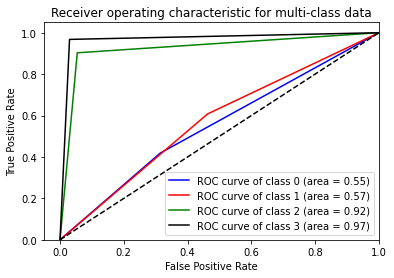

In [309]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
from itertools import cycle
import matplotlib.pyplot as plt
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_2[:, i], y_pred_2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [212]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_sample(x2, y2)
 
sorted(Counter(y_resampled).items())

[('1-30days', 21408), ('31-60days', 21714), ('=<0', 21982), ('>60', 18398)]

In [243]:
x_test_2

,Key Account,Key Region,long term,week_pay,week_due,Direct Debits 2,No Payment Method,Regulatory 2,Third Part Payments,Wire,Regulatory 1,Regulatory,low,medium,medium-high
13128,1,0,0,2,5,1,0,0,0,0,0,0,1,0,0
34679,1,0,0,3,6,0,0,0,0,0,0,0,0,1,0
431,1,0,1,0,5,1,0,0,0,0,0,0,1,0,0
12770,1,1,0,5,1,1,0,0,0,0,0,0,0,0,0
5304,1,1,0,0,6,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36028,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1
22150,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0
36747,1,1,0,1,2,0,0,0,0,0,0,0,0,1,0
25425,1,0,1,1,2,1,0,0,0,0,0,0,0,0,0


In [248]:
y_pred_2

array(['1-30days', '1-30days', '1-30days', ..., '=<0', '=<0', '=<0'],
      dtype=object)

In [247]:
y_test_2

13128                                                1-30days
34679                                                     =<0
431                                                  1-30days
12770                                                1-30days
5304                                                 1-30days
                                  ...                        
22150                                                     =<0
36747                                                     =<0
25425                                                     =<0
41124                                                     =<0
y_pred_2    [1-30days, 1-30days, 1-30days, 1-30days, 1-30d...
Name: flag, Length: 9170, dtype: object